# MNIST Digits Classification using Neural Networks



In this part we will implement our first Neural Network!
We will use fully connecter Neural Network in order to classify handwritten digits. We will use the well known MNIST dataset. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports

In [ ]:
#importing modules that will be in use
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



Mount your drive in order to run locally with colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/deep learning/ex2/FC
from utils import *

Mounted at /content/drive
/content/drive/MyDrive/deep learning/ex2/FC


**QUESTION 1**: What are the problems with sigmoid?

**ANSWER**: That the values of the outputs are only postive, so the net can't make the output values negtive even if it is needed.
Also, in very big numbers or very small the derivative what will make the net need more epochs to train.








here we will implement the sigmoid activation function and it's gradient. You should not use any build-in function of sigmoid.

In [ ]:

def sigmoid(x):
    # impement the sigmoid funciton
    # ====== YOUR CODE: ======
    sig = 1/(1+torch.exp(-x))
    # ========================
    return sig



def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A torch array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A torch array of shape (N, C) containing the softmax probabilities.

     """
    #for stability (do not change)
    max_per_row, inds = torch.max(x, dim=1)
    x = (x.T - max_per_row).T
    
    # ====== YOUR CODE: ======   
    exp_x = torch.exp(x)
    sum_exp_x = torch.sum(exp_x, dim=1)
    
    # compute the softmax probabilities
    probabilities = exp_x / sum_exp_x.view(-1,1)
    # ========================
    return probabilities

Implement a fully-vectorized loss function for the Softmax classifier.


In [ ]:
def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A torch array of shape (N,C) containing  a minibatch of training label. it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: A torch array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """
     # ====== YOUR CODE: ======   
    epsilon = 1e-10  # Small value to avoid division by zero
    y_pred = torch.clamp(y, epsilon, 1.0 - epsilon)

    # Compute the cross-entropy loss
    error = torch.mean(-torch.sum(t * torch.log(y_pred), dim=1))
    # ========================
    return error

In [ ]:
def get_accuracy(y,t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A torch array of shape (N,C) containing training labels, it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: the torch probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    # ====== YOUR CODE: ======  
    _, y_pred = torch.max(y, dim=1)
    _, t_pred = torch.max(t, dim=1)
    num_correct = torch.sum(y_pred == t_pred)
    accuracy = num_correct.item() / y.size(0)
    # ========================    
    return accuracy



## Fully-connected Network

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

We will use torch.nn for the linear functions



### config

In [ ]:
args={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=15  #The number of Epochs
args['validation_ratio']=0.15 #The validation ratio from training set  
args['eval_every']=1 #Will evaluate the model ever <eval_every> epochs

## load the data

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [ ]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
        
    # TODO: Create two DataLoader instances, dataloader_train and dataloader_valid.
    # They should together represent a train/validation split of the given
    # dataset. Make sure that:
    # 1. Validation set size is validation_ratio * total number of samples.
    # 2. No sample is in both datasets. You can select samples at random
    #    from the dataset.
    # 3. you use shuffle=True in the train dataloader and shuffle=False in the validation dataloder
    

    # ====== YOUR CODE: ======
    dataset_train, dataset_valid = train_test_split(dataset,test_size=validation_ratio, random_state=42)
    dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
    dl_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=2)
    # ========================

    return dl_train, dl_valid

In [ ]:
#load the data
dataset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,), (0.3081,))])
                        )

train_loader, val_loader = create_train_validation_loaders(dataset, 
                                                           validation_ratio = args['validation_ratio'],
                                                           batch_size= args['batch_size'])

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [ ]:
dataloaders = {'training':train_loader,
               'val':val_loader,
               'test':test_loader
              }

## Fully connected Neural Network

In [ ]:
class FullyConnectedNeuralNetwork(nn.Module):
    #This defines the structure of the NN.
    def __init__(self, hidden_layer_dim):
      super(FullyConnectedNeuralNetwork, self).__init__()
      # Define the model layers. 
      # Use the torch.nn.Linear layers. Set the hidden layer dim to hidden_layer_dim. 
      # Notice that the input dim is 784 and the output dim is 10 (number of classes).
      # ====== YOUR CODE: ======
      self.fc1 = nn.Linear(784, hidden_layer_dim) # 784 input dim (after flatten), hidden_layer_dim output channels 
      self.fc2 = nn.Linear(hidden_layer_dim, 10) # hidden_layer_dim input dim, 10 output channels 
      self.sigmoid = sigmoid
      self.softmax = softmax
      # ========================

    def forward(self, x):
      x = torch.flatten(x, start_dim=1,end_dim=-1)
      # ====== YOUR CODE: ======
      y = self.fc1(x)
      y = self.sigmoid(y)
      y = self.fc2(y)
      y = self.softmax(y)
      # ========================
      return y

The following functions will train our model

In [ ]:
def forward_one_epoch(loader,
                      optimizer,
                      net,
                      mode,
                      progress_bar_str,
                      num_of_epochs
                     ):
    

    losses, cur_accuracies = [], []
    all_preds,all_targets = [], []
    for batch_idx, (inputs, targets) in enumerate(loader):
        
        if mode == Mode.training:
            optimizer.zero_grad()
            
        inputs, targets =inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets = F.one_hot(targets, num_classes=10)
        loss = cross_entropy_error(outputs, targets)
        losses.append(loss.item())

        if mode == Mode.training:
            #do a step 
            loss.backward()
            optimizer.step()
            
        if len(targets.shape) ==2:
            cur_accuracies.append(get_accuracy(outputs, targets))
            
        if batch_idx %20 ==0:
            progress_bar(batch_idx, len(loader), progress_bar_str
                   % (num_of_epochs, np.mean(losses), losses[-1], np.mean(cur_accuracies)))
            
        targets_cpu = targets.cpu().data.numpy()
        outputs_cpu = [i.cpu().data.numpy() for i in outputs]
        outputs_cpu = np.argmax(outputs_cpu, axis=1)

        all_targets.extend(targets_cpu)
        all_preds.extend(outputs_cpu)

        del inputs, targets, outputs
        torch.cuda.empty_cache()


    return losses, cur_accuracies, all_targets, all_preds




In [ ]:
def train(args, dataloaders):
  seed = 0
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  model = FullyConnectedNeuralNetwork(hidden_layer_dim = args['hidden_layer_dim'])
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), args['lr'])

  training_accuracies, val_accuracies = [], []
  training_losses, val_losses = [], [] 


  training_loader = dataloaders['training']
  val_loader = dataloaders['val']
  test_loader = dataloaders['test']

  best_acc = -1

  #start training
  for epoch in range(1, args['epochs']+1):

      #training
      model = model.train()

      progress_bar_str = 'Train: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Train Acc: %.3f%%' 

      losses, cur_training_accuracies, _,_ =  forward_one_epoch(
          loader = training_loader,
          optimizer = optimizer,
          net = model,
          mode = Mode.training,
          progress_bar_str = progress_bar_str,
          num_of_epochs = epoch)


      train_epoch_acc = np.mean(cur_training_accuracies)
      train_epoch_loss= np.mean(losses)
      sys.stdout.flush()
      print()
      print(f'Train epoch {epoch}: accuracy {train_epoch_acc}, loss {train_epoch_loss}', flush=True)
      training_accuracies.append(train_epoch_acc)
      training_losses.append(train_epoch_loss)



      # validation
      model.eval()
      if (epoch-1)%args['eval_every']==0:
          progress_bar_str = 'Validation: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | val Acc: %.3f%%'

          losses, cur_val_accuracies,_,_ =  forward_one_epoch(val_loader,
                                                                optimizer,
                                                                model,
                                                                Mode.validation,
                                                                progress_bar_str,
                                                                epoch
                                                              )
          val_epoch_acc= np.mean(cur_val_accuracies)
          val_epoch_loss= np.mean(losses)
          sys.stdout.flush()
          val_accuracies.append(val_epoch_acc)

          val_epoch_acc = np.round(val_epoch_acc,3)
          print()
          print(f'Validation epoch {epoch//args["eval_every"]}: accuracy {val_epoch_acc}, loss {val_epoch_loss}', flush=True)
          val_losses.append(val_epoch_loss)
          
          cur_acc_loss = {
            'training_accuracies':training_accuracies,
            'val_accuracies':val_accuracies,
            'training_losses':training_losses,
            'val_losses':val_losses
                        }

          if best_acc +0.001 < val_epoch_acc:

              best_acc = val_epoch_acc
              best_acc_epoch = epoch

              print(f'========== new best model! epoch {best_acc_epoch}, accuracy {best_acc}  ==========')
              best_model = copy.deepcopy(model)

              
  progress_bar_str = 'Test: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Acc: %.3f%%'
  test_losses, test_cur_test_accuracies, test_all_targets, test_all_preds = forward_one_epoch(test_loader,
                                                                None,
                                                                best_model,
                                                                Mode.test,
                                                                progress_bar_str,
                                                                0)

  test_epoch_acc= np.mean(test_cur_test_accuracies)
  test_epoch_loss= np.mean(test_losses)
  print("===================== Test Results =====================")
  print(f'Test Accuracy : {test_epoch_acc}')
  print(f'Test Loss : {test_epoch_loss}')
  return best_model, cur_acc_loss 

## Training Process

We will finetune two hyper parameters:
1. The hidden layer dimension.
2. The learning rate.

### Finetuning hidden_layer_dim 

#### hidden_layer_dim = 1, lr = 0.0001  

Set the hidden_layer_dim to 1 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 1
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.1039607843137255, loss 2.56871062634038

Validation epoch 1: accuracy 0.107, loss 2.5575113561418323
========== new best model! epoch 1, accuracy 0.107  ==========

Train epoch 2: accuracy 0.10396078431372548, loss 2.5604490065107157

Validation epoch 2: accuracy 0.107, loss 2.5493870311313205

Train epoch 3: accuracy 0.10396078431372548, loss 2.5524757796642827

Validation epoch 3: accuracy 0.107, loss 2.541581975089179

Train epoch 4: accuracy 0.1039607843137255, loss 2.544849157333374

Validation epoch 4: accuracy 0.107, loss 2.5341508388519287

Train epoch 5: accuracy 0.1039607843137255, loss 2.5376140229842243

Validation epoch 5: accuracy 0.107, loss 2.527128325568305

Train epoch 6: accuracy 0.1039607843137255, loss 2.5307956723605884

Validation epoch 6: accuracy 0.107, loss 2.5205311510297985

Train epoch 7: accuracy 0.1039607843137255, loss 2.5244068164451448

Validation epoch 7: accuracy 0.107, loss 2.514367527431912

Train epoch 8: accuracy 0.1039

Best val accuracy was 0.10700000000000001, at epoch 5


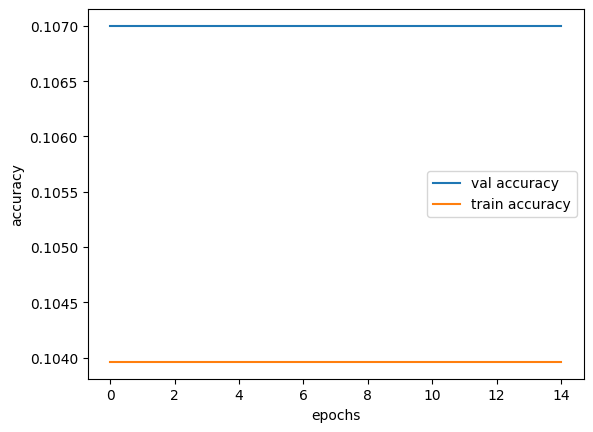

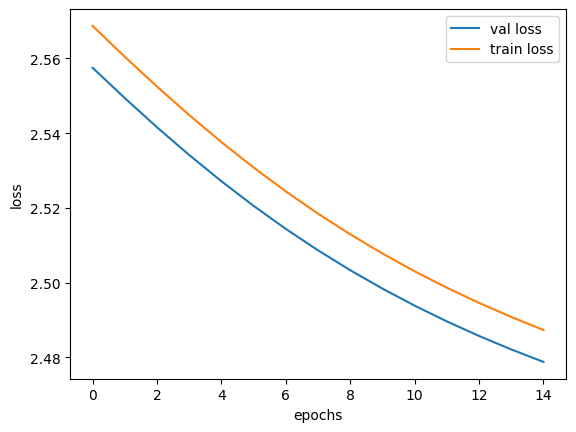

0.10700000000000001

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: We can learn that in 1 hidden layer the model isn't training becuase the accuracy isn't changing. Probably, we will need more layers for the model to be stronger and will find the right function. 



#### hidden_layer_dim = 5, lr = 0.0001

Set the hidden_layer_dim to 5 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 5
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.11286274509803922, loss 2.3576437491996614

Validation epoch 1: accuracy 0.11, loss 2.360462294684516
========== new best model! epoch 1, accuracy 0.11  ==========

Train epoch 2: accuracy 0.1128627450980392, loss 2.355634796853159

Validation epoch 2: accuracy 0.11, loss 2.3584760824839273

Train epoch 3: accuracy 0.11286274509803922, loss 2.353651481516221

Validation epoch 3: accuracy 0.11, loss 2.3565157784356012

Train epoch 4: accuracy 0.11288235294117646, loss 2.3516940743315455

Validation epoch 4: accuracy 0.11, loss 2.354581673940023

Train epoch 5: accuracy 0.11290196078431372, loss 2.3497630100624236

Validation epoch 5: accuracy 0.11, loss 2.352673795488146

Train epoch 6: accuracy 0.11290196078431375, loss 2.3478584850535675

Validation epoch 6: accuracy 0.11, loss 2.350792752371894

Train epoch 7: accuracy 0.11294117647058825, loss 2.3459806769501927

Validation epoch 7: accuracy 0.11, loss 2.348938306172689

Train epoch 8: accuracy 0.112941176

Best val accuracy was 0.11044444444444444, at epoch 0


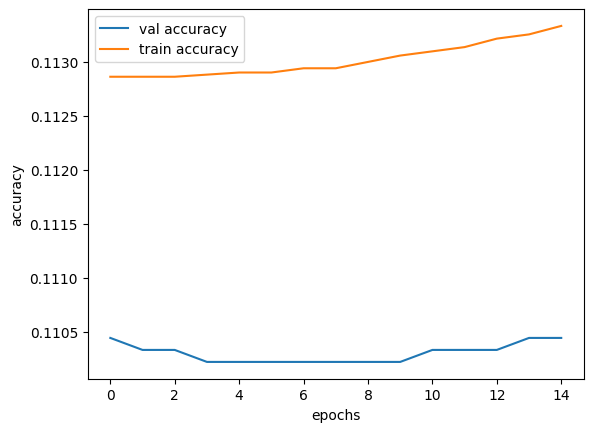

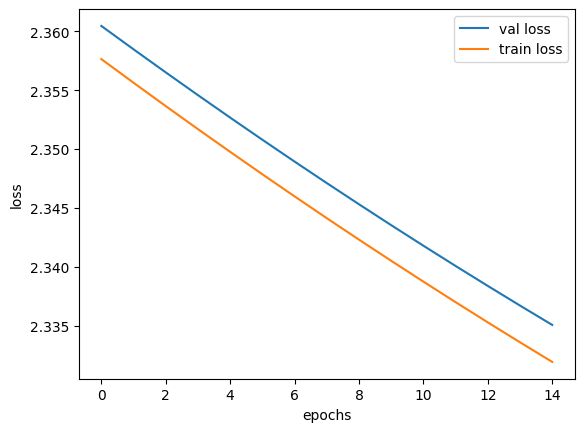

0.11044444444444444

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: We can learn that in 5 hidden layer the model isn't training becuase the accuracy isn't changing. Probably, we will need more layers for the model to be stronger and will find the right function. But we can see an improvement for the 1 dim hidden layer model, so we will need to add even more.

#### hidden_layer_dim = 100, lr = 0.0001

Set the hidden_layer_dim to 100 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.1059607843137255, loss 2.3355661093019973

Validation epoch 1: accuracy 0.111, loss 2.3340393437279596
========== new best model! epoch 1, accuracy 0.111  ==========

Train epoch 2: accuracy 0.10707843137254902, loss 2.3334949016571045

Validation epoch 2: accuracy 0.112, loss 2.3320122559865317

Train epoch 3: accuracy 0.10811764705882354, loss 2.3314495600906073

Validation epoch 3: accuracy 0.113, loss 2.330010175704956
========== new best model! epoch 3, accuracy 0.113  ==========

Train epoch 4: accuracy 0.10943137254901962, loss 2.329429369346768

Validation epoch 4: accuracy 0.115, loss 2.3280327055189343
========== new best model! epoch 4, accuracy 0.115  ==========

Train epoch 5: accuracy 0.11047058823529413, loss 2.32743361416985

Validation epoch 5: accuracy 0.115, loss 2.3260792361365423

Train epoch 6: accuracy 0.11174509803921569, loss 2.3254620608161476

Validation epoch 6: accuracy 0.117, loss 2.3241488933563232
========== new best model! epo

Best val accuracy was 0.12677777777777777, at epoch 14


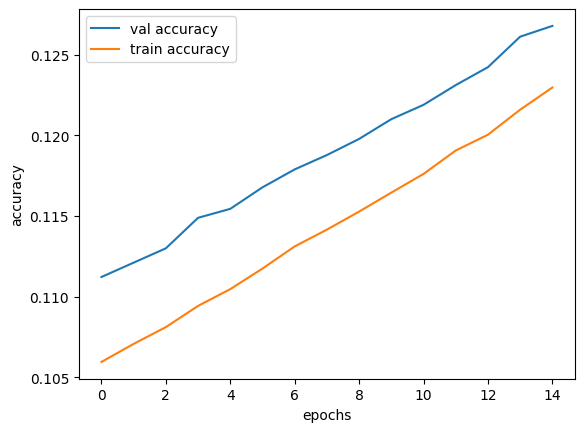

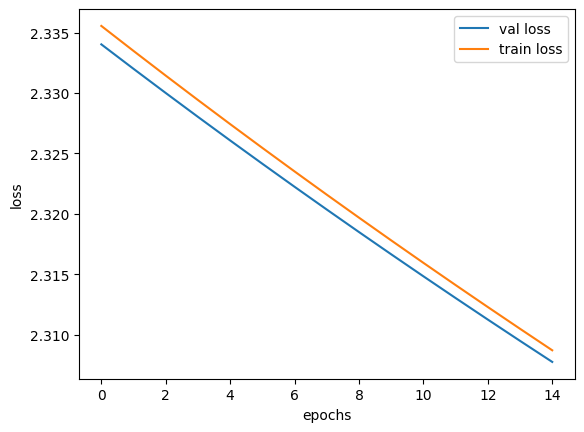

0.12677777777777777

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: From those graphs we can see the the accuracy is going up and better than the other models. Also, the error values are going down in a really low pace. 

#### hidden_layer_dim = 200, lr = 0.0001

Set the hidden_layer_dim to 200 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 200
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.14778431372549022, loss 2.3084230469722375

Validation epoch 1: accuracy 0.149, loss 2.3090303209092884
========== new best model! epoch 1, accuracy 0.149  ==========

Train epoch 2: accuracy 0.15301960784313728, loss 2.3061136825411928

Validation epoch 2: accuracy 0.156, loss 2.306707673602634
========== new best model! epoch 2, accuracy 0.156  ==========

Train epoch 3: accuracy 0.15854901960784315, loss 2.3038563073850145

Validation epoch 3: accuracy 0.163, loss 2.304437186982897
========== new best model! epoch 3, accuracy 0.163  ==========

Train epoch 4: accuracy 0.16441176470588234, loss 2.3016480651556277

Validation epoch 4: accuracy 0.168, loss 2.3022149403889975
========== new best model! epoch 4, accuracy 0.168  ==========

Train epoch 5: accuracy 0.17074509803921573, loss 2.2994858844607484

Validation epoch 5: accuracy 0.175, loss 2.3000397417280407
========== new best model! epoch 5, accuracy 0.175  ==========

Train epoch 6: accuracy 0.17680

Best val accuracy was 0.2287777777777778, at epoch 14


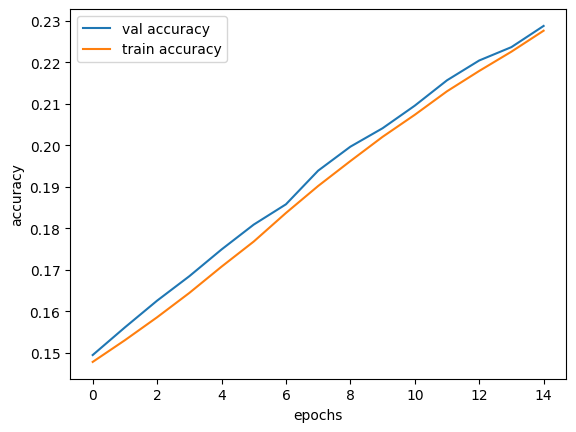

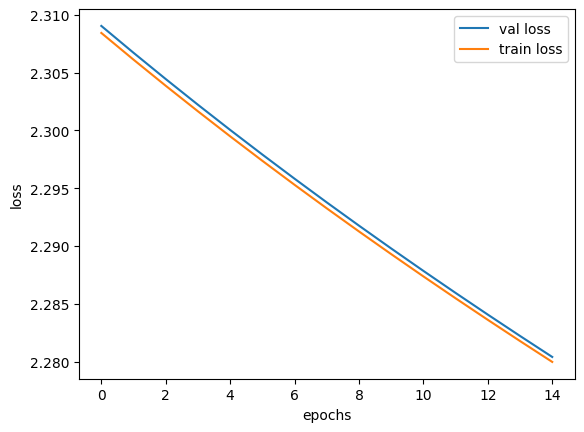

0.2287777777777778

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.4**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: In this model we can see that the results are better becuse the error is going down by more the the other model we have try so far. Fro the graphs we can learn the the model is traning and we have a progress of better results.

### Finetuning learning rate

#### hidden_layer_dim = 100, lr = 0.000001

Set the hidden_layer_dim to 100 and the lr to 0.000001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.000001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.10527450980392158, loss 2.3365778829537187

Validation epoch 1: accuracy 0.11, loss 2.336071915096707
========== new best model! epoch 1, accuracy 0.11  ==========

Train epoch 2: accuracy 0.10529411764705883, loss 2.3365571358624626

Validation epoch 2: accuracy 0.11, loss 2.336051411098904

Train epoch 3: accuracy 0.10529411764705883, loss 2.336536337347592

Validation epoch 3: accuracy 0.11, loss 2.336030960083008

Train epoch 4: accuracy 0.10531372549019608, loss 2.336515599606084

Validation epoch 4: accuracy 0.11, loss 2.3360105090671115

Train epoch 5: accuracy 0.10531372549019609, loss 2.3364948291404573

Validation epoch 5: accuracy 0.11, loss 2.335990031560262

Train epoch 6: accuracy 0.10533333333333335, loss 2.3364740820492016

Validation epoch 6: accuracy 0.11, loss 2.3359696335262723

Train epoch 7: accuracy 0.10533333333333333, loss 2.3364532835343303

Validation epoch 7: accuracy 0.11, loss 2.3359491295284696

Train epoch 8: accuracy 0.1053333

Best val accuracy was 0.11055555555555556, at epoch 14


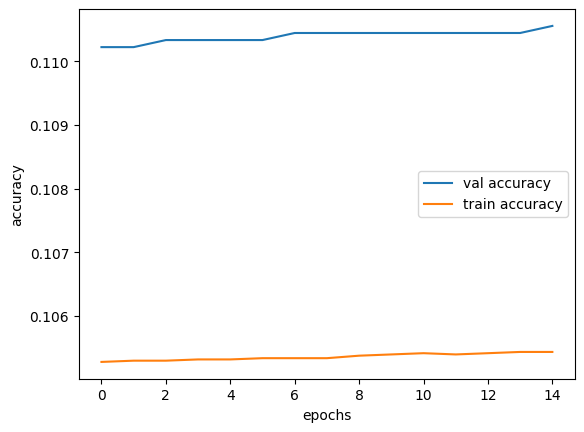

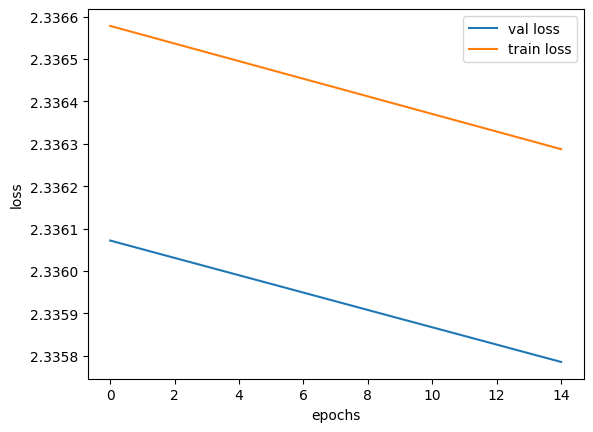

0.11055555555555556

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: We can see that the accuracy isn't changing so the model isnt trainng. In the graph we can see that there is a progress but it is very slow.
The model need a higher learning rate.

#### hidden_layer_dim = 100, lr = 0.1

Set the hidden_layer_dim to 1 and the lr to 0.1 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']= 0.1
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.612078431372549, loss 1.7780668922499114

Validation epoch 1: accuracy 0.753, loss 1.2863095601399739
========== new best model! epoch 1, accuracy 0.753  ==========

Train epoch 2: accuracy 0.7981372549019607, loss 1.0126331939416773

Validation epoch 2: accuracy 0.823, loss 0.8186392982800802
========== new best model! epoch 2, accuracy 0.823  ==========

Train epoch 3: accuracy 0.8478431372549019, loss 0.7075063632983788

Validation epoch 3: accuracy 0.856, loss 0.6252166893747118
========== new best model! epoch 3, accuracy 0.856  ==========

Train epoch 4: accuracy 0.8699019607843138, loss 0.5678575582364026

Validation epoch 4: accuracy 0.873, loss 0.5241571068763733
========== new best model! epoch 4, accuracy 0.873  ==========

Train epoch 5: accuracy 0.8824313725490196, loss 0.4897039374884437

Validation epoch 5: accuracy 0.883, loss 0.46310020486513775
========== new best model! epoch 5, accuracy 0.883  ==========

Train epoch 6: accuracy 0.89001960

Best val accuracy was 0.9138888888888889, at epoch 14


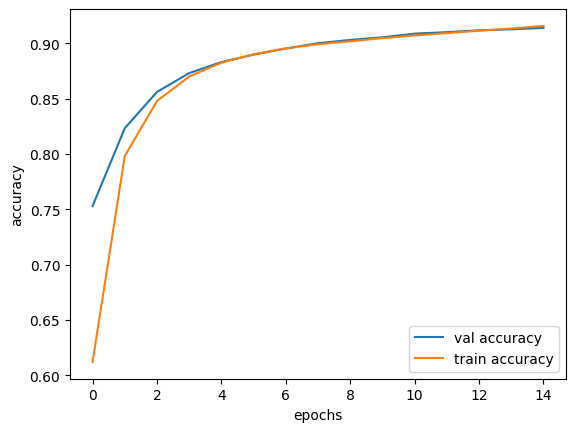

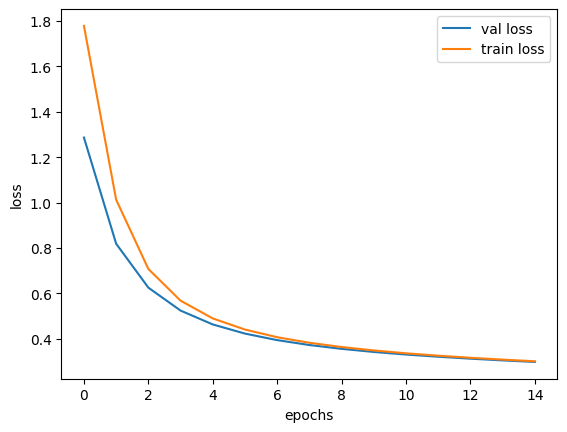

0.9138888888888889

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: In this model we can see the results we expected. the accuarcy increase with every epoch and the error is decreasing. The model have an accuracy of over 90%(the goal we set up for that model) and the error is closer to 0.

#### hidden_layer_dim = 100, lr = 0.001

Set the hidden_layer_dim to 100 and the lr to 0.001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.11090196078431373, loss 2.3267259364034616

Validation epoch 1: accuracy 0.121, loss 2.316638390223185
========== new best model! epoch 1, accuracy 0.121  ==========

Train epoch 2: accuracy 0.12350980392156861, loss 2.308051123338587

Validation epoch 2: accuracy 0.132, loss 2.2992665767669678
========== new best model! epoch 2, accuracy 0.132  ==========

Train epoch 3: accuracy 0.13715686274509806, loss 2.2912415195913876

Validation epoch 3: accuracy 0.147, loss 2.283497783872816
========== new best model! epoch 3, accuracy 0.147  ==========

Train epoch 4: accuracy 0.1523921568627451, loss 2.2758720622343174

Validation epoch 4: accuracy 0.163, loss 2.2689709663391113
========== new best model! epoch 4, accuracy 0.163  ==========

Train epoch 5: accuracy 0.16960784313725488, loss 2.2616188011917413

Validation epoch 5: accuracy 0.181, loss 2.255402432547675
========== new best model! epoch 5, accuracy 0.181  ==========

Train epoch 6: accuracy 0.18901960

Best val accuracy was 0.5079999999999999, at epoch 14


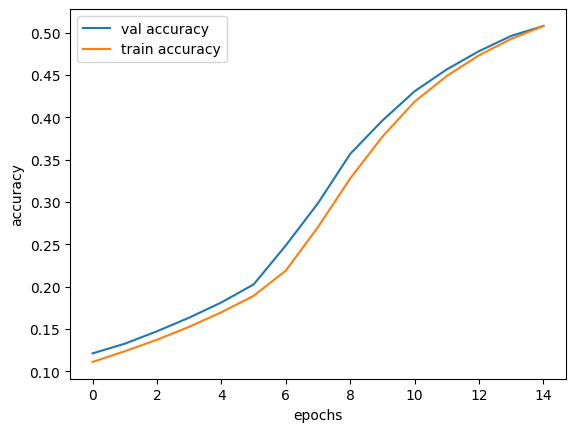

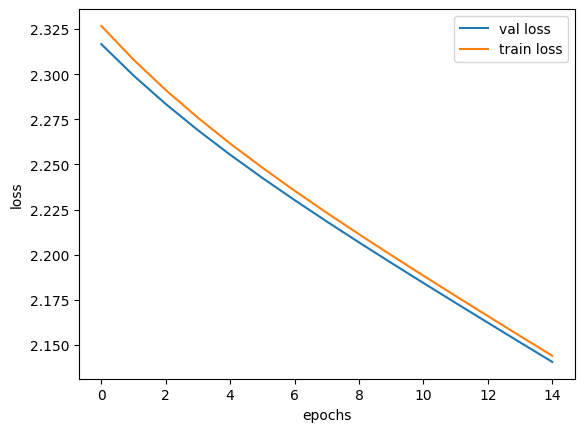

0.5079999999999999

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: In this model the model is traing but in a slower pace. the accuracy is more than 50%, its means that the mode is traning. The model with the previus learning rate was bettter so we will choose it.


**QUESTION 4:** : Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**: 
There are few ways to improve a net:
1. we can add regularization for the error of the model.
2. Add more hidden layers to the net.
3. Try different activtion function. 




## Explainability

Here we will plot some of the network weights.
**Be sure you run this cell with your best model!**

(784, 100)


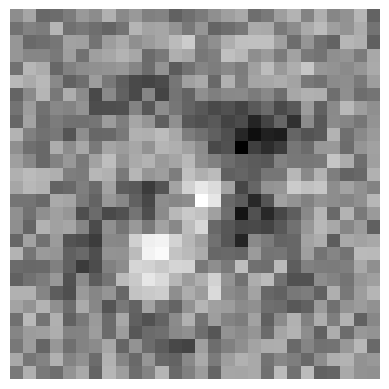

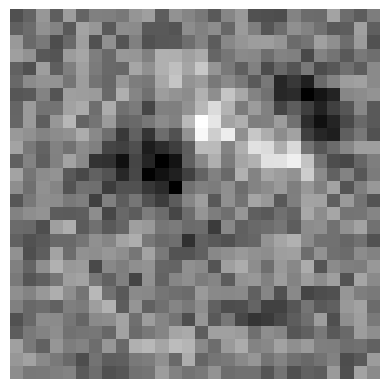

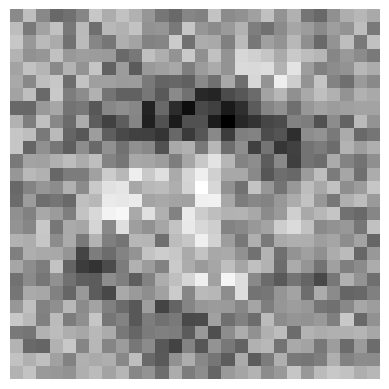

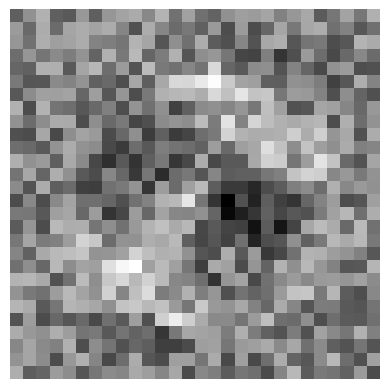

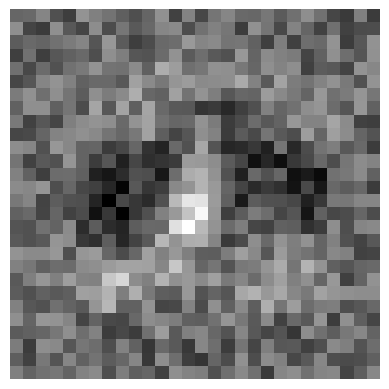

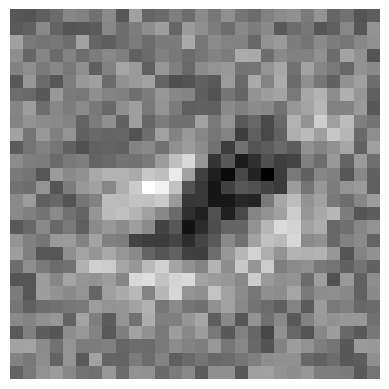

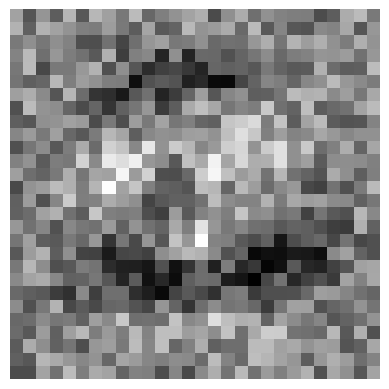

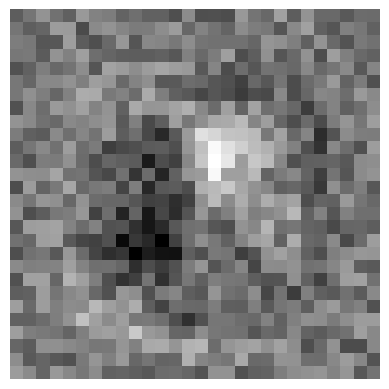

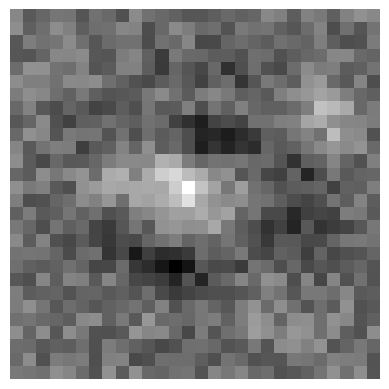

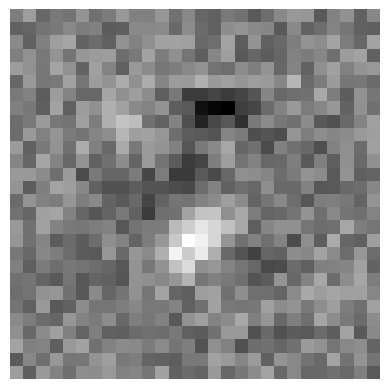

In [ ]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(net_params):
    W1 = net_params.fc1.weight.cpu().data.numpy().T
    print(W1.shape)
    for i in range(10):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(best_model)


**QUESTION 5:** Where are the bright regions? why?

**ANSWER:** The bright regions in the displayed images indicate areas where the neural network is most activated and where the corresponding weights have higher positive values. This is because in grayscale images, black is represented by the number 0 and white by the number 255. Therefore, brighter regions signify stronger connections or emphasis on those particular pixels, suggesting their importance in recognizing and distinguishing the respective digit.